In [46]:
import pandas as pd
import os
import json
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
def read_file(fpath):
    with open(fpath) as reader:
        return json.load(reader)["query_level"]

def read_results(path, flat=True):
    results = {}
    cqa = {}
    for fname in os.listdir(path):
        if not fname.endswith(".json"):
            continue

        if fname.startswith("dl") or fname.startswith("dev") and "scifact" not in fname:
            results[fname.split("_")[0].rstrip(".json")] = read_file(path/fname)
        elif "scifact" in fname:
            results["scifact"] = read_file(path/fname)
        elif fname.startswith("bier_test") and "cqa" not in fname:
            results[fname.split("_")[2].rstrip(".json")] = read_file(path/fname)
        elif "cqa" in fname:
            cqa_split = fname.split("_")[2].rstrip(".json")
            queries = read_file(path/fname)
            cqa.update({cqa_split + "_" + qid: mets for qid, mets in queries.items()})
        else:
            print(fname)
    results["cqa"] = cqa
    mean_results_raw = defaultdict(lambda: defaultdict(list))
    mean_results = {}
    for dname, queries in results.items():
        for qid, perfs in queries.items():
            for met, val in perfs.items():
                mean_results_raw[dname][met].append(val)


        if not flat:
            mean_results[dname] = {}

        
        for met, vals in mean_results_raw[dname].items():
            if met not in METRIC_SETS[dname]:
                continue
            if flat:
                mean_results[f"{dname}_{met}"] = round(np.mean(vals), 4)
            else:
                mean_results[dname][met] = round(np.mean(vals), 4)
    
    return mean_results, mean_results_raw


METRIC_SETS = {
    "dev": {"recip_rank_cut_10", "map"},
    "dl19": {"ndcg_cut_10", "map"},
    "dl20": {"ndcg_cut_10", "map"},
    "scifact": {"ndcg_cut_10"},
    "cqa": {"ndcg_cut_10"},
    "trec-covid": {"ndcg_cut_10"},
    "fiqa": {"ndcg_cut_10"},
}


MODELS = {
    "DPR":  Path("../runs/dpr/"),
    "TAS-B (0s)":  Path("../runs/tasb/"),
    "MVRL (DB, ND)": Path("../runs/mvrl_nd_updated"),
    "MVRL (DB, ND, LV)": Path("../runs/mvrl_nd_db_logvar_updated"),
    "MVRL (ND)": Path("../runs/mvrl_nd_tasb_2_updated"),
    
    "MVRL (ND, LV)": Path("../runs/mvrl_nd_tasb_logvar_updated/"),
    "MVRL-ND-TASB-Logvar-2GPU": Path("../runs/mvrl_nd_tasb_logvar_2gpu_updated/"),

    "MVRL-(ND, LV BZ-128)": Path("../runs/mvrl_nd_tasb_logvar_128_updated/"),
    "MVRL-(ND, LV BZ-256)": Path("../runs/mvrl_nd_tasb_logvar_256_updated/"),
    "MVRL-(ND, LV BZ-512)": Path("../runs/mvrl_nd_tasb_logvar_512_updated/"),
    
    "MVRL": Path("../runs/mvrl/"),
    "CLDRD": Path("../runs/cldrd/"),
    
    
    "MVRL (DB, ND, LV) (Mean)": Path("../runs/mvrl_nd_db_logvar_mean"),
    "MVRL (ND) (Mean)": Path("../runs/mvrl_nd_tasb_2_mean/"),
    "MVRL (DB, ND) (Mean)": Path("../runs/mvrl_nd_db_mean/"),
    "MVRL (ND, LV) (Mean)": Path("../runs/mvrl_nd_tasb_logvar_mean/"),
    "MVRL-(ND, LV BZ-128) (Mean)": Path("../runs/mvrl_nd_tasb_logvar_128_mean/"),
    "MVRL-(ND, LV BZ-256) (Mean)": Path("../runs/mvrl_nd_tasb_logvar_256_mean/"),
    "MVRL-(ND, LV BZ-512) (Mean)": Path("../runs/mvrl_nd_tasb_logvar_512_mean/"),
    
    
    "MVRL (DB, ND) (Original)": Path("../runs/mvrl_nd_original"),
    "MVRL-(DB, ND, LV) (Original)": Path("../runs/mvrl_nd_db_logvar_original"),
    "MVRL (ND) (Original)": Path("../runs/mvrl_nd_tasb_2_original"),
    "MVRL (ND, LV) (Original)": Path("../runs/mvrl_nd_tasb_logvar_original/"),
    "MVRL-(ND, LV BZ-128) (Original)": Path("../runs/mvrl_nd_tasb_logvar_128_original/"),
    "MVRL-(ND, LV BZ-256) (Original)": Path("../runs/mvrl_nd_tasb_logvar_256_original/"),
    "MVRL-(ND, LV BZ-512) (Original)": Path("../runs/mvrl_nd_tasb_logvar_512_original/"),
    

    "MVRL-ND-EDT": Path("../runs/mvrl_nd_db_edt_updated"),
    "MVRL-ND-EDT (Original)": Path("../runs/mvrl_nd_db_edt_original"),

    "MCDropout-DB": Path("../runs/stoch_db/"),
    "MCDropout-DB-Frozen": Path("../runs/stoch_db_frozen/"),
    "MCDropout-TASB": Path("../runs/stoch_tasb/"),
    "MCDropout-TASB-Frozen": Path("../runs/stoch_tasb_frozen/"),
}



MEAN_RESULTS = {}
MEAN_RESULTS_RAW = {}
for model_name, res_path in MODELS.items():
    m, r = read_results(res_path)
    m["model"] = model_name
    MEAN_RESULTS[model_name] = m
    MEAN_RESULTS_RAW[model_name] = r

In [3]:
len(MEAN_RESULTS)

32

In [4]:
COL_ORDER = ['model',
 'dev_recip_rank_cut_10',
 'dev_map',
 'dl19_ndcg_cut_10',
 'dl19_map',
 'dl20_ndcg_cut_10',
 'dl20_map',
 'scifact_ndcg_cut_10',
 'fiqa_ndcg_cut_10',
 'trec-covid_ndcg_cut_10', 
 'cqa_ndcg_cut_10',
 ]


In [5]:
all_res_df = pd.DataFrame(MEAN_RESULTS.values())[COL_ORDER]
all_res_df

,model,dev_recip_rank_cut_10,dev_map,dl19_ndcg_cut_10,dl19_map,dl20_ndcg_cut_10,dl20_map,scifact_ndcg_cut_10,fiqa_ndcg_cut_10,trec-covid_ndcg_cut_10,cqa_ndcg_cut_10
0,DPR,0.3125,0.3192,0.6490,0.3449,0.6246,0.3560,0.4740,0.2309,0.5996,0.2729
1,TAS-B (0s),0.3443,0.3509,0.7210,0.3956,0.6850,0.4298,0.6428,0.3007,0.4812,0.3195
2,"MVRL (DB, ND)",0.3154,0.3219,0.6360,0.3481,0.6311,0.3655,0.4940,0.2440,0.5741,0.2868
3,"MVRL (DB, ND, LV)",0.3161,0.3223,0.6357,0.3493,0.6249,0.3634,0.4966,0.2357,0.5517,0.2859
4,MVRL (ND),0.3279,0.3342,0.6288,0.3896,0.6438,0.4097,0.4976,0.2446,0.4729,0.2746
5,"MVRL (ND, LV)",0.3304,0.3366,0.6409,0.3879,0.6471,0.4062,0.5231,0.2411,0.3422,0.2706
6,MVRL-ND-TASB-Logvar-2GPU,0.3332,0.3397,0.6522,0.3997,0.6588,0.4187,0.5194,0.2496,0.3761,0.2775
7,"MVRL-(ND, LV BZ-128)",0.3398,0.3464,0.6638,0.4217,0.6614,0.4373,0.5341,0.2636,0.4503,0.2899
8,"MVRL-(ND, LV BZ-256)",0.3413,0.3481,0.6832,0.4313,0.6691,0.4427,0.5484,0.2673,0.4423,0.2958
9,"MVRL-(ND, LV BZ-512)",0.3410,0.3480,0.6786,0.4329,0.6737,0.4464,0.5565,0.2688,0.4533,0.2980


In [6]:
all_res_df.to_clipboard(index=False)

In [41]:
# gathe QPP results
qpp_output_dir = Path("../qpp_output/")
QPP_BASELINES = ["VAR", "SCQ", "IDF", "SCS", "PMI"]
QPP_MODELS = ["MVRL", "MVRL_ND", "MVRL_ND_TASB", "MVRL_TASB_LOGVAR",
              "STOCH_DB", "STOCH_DB_FROZEN", "STOCH_TASB", "STOCH_TASB_FROZEN", ]

MODEL_REFS = ["bm25", "tasb", "dpr", "mvrl_nd"]

qpp_rows = []
qpp_bl_rows = []

for dataset in {"dl19", "dl20"}:
    result = pd.read_csv(qpp_output_dir/ (dataset + ".csv"))
    for ref in MODEL_REFS:
        for qpp_model in QPP_MODELS:
            rel_rows = result[result["ref"] == ref]
            rel_rows = rel_rows[rel_rows["method"].apply(lambda _: qpp_model == _)]
            # select best one
            rel_rows = rel_rows.sort_values(by="ktau", ascending=False)
            res_raw = rel_rows.to_dict("records")[0]
            res = {}
            for k, v in res_raw.items():
                if isinstance(v, float):
                    res[k] = round(v, 4)
                else:
                    res[k] = v
            res["dataset"] = dataset
            qpp_rows.append(res)

        for qpp_model in QPP_BASELINES:
            rel_rows = result[result["ref"] == ref]
            rel_rows = rel_rows[rel_rows["method"].apply(lambda _: qpp_model in _)]
            # select best one
            rel_rows = rel_rows.sort_values(by="ktau", ascending=False)
            res_raw = rel_rows.to_dict("records")[0]
            res = {}
            for k, v in res_raw.items():
                if isinstance(v, float):
                    res[k] = round(v, 4)
                else:
                    res[k] = v
            res["dataset"] = dataset
            qpp_bl_rows.append(res)
        

QPP_ORDER = ["dataset", "ref", "method", "spearman", "pearson", "ktau"]
qpp_df = pd.DataFrame(qpp_rows)[QPP_ORDER]
qpp_bl_df = pd.DataFrame(qpp_bl_rows)[QPP_ORDER]

In [45]:
pd.DataFrame(qpp_bl_rows)["method"].unique()

array(['VAR-var-avg', 'SCQ-sum', 'IDF-std', 'SCS-1', 'PMI-avg',
       'VAR-std-sum', 'IDF-sum', 'PMI-sum', 'PMI-max', 'SCQ-avg',
       'IDF-avg', 'SCS-2', 'VAR-std-max', 'SCQ-max'], dtype=object)

In [17]:
qpp_bl_df.to_clipboard(index=False)

In [12]:
qpp_df.to_clipboard(index=False)

In [58]:
df = pd.read_csv("./qpp_checkpoints.csv")
#df = pd.read_clipboard()
#df.to_csv("./qpp_checkpoints.csv", index=False)

In [59]:
df

,dataset,ref,checkpoint,spearman,pearson,ktau
0,dl19,bm25,25000,0.0610,0.1261,0.0365
1,dl19,dpr,25000,-0.0897,-0.0933,-0.0643
2,dl19,tasb,25000,-0.1844,-0.1421,-0.1220
3,dl19,bm25,50000,-0.0387,-0.0067,-0.0144
4,dl19,dpr,50000,-0.0369,-0.0313,-0.0288
5,dl19,tasb,50000,-0.1021,-0.0996,-0.0643
6,dl19,bm25,100000,0.1433,0.1237,0.0986
7,dl19,dpr,100000,-0.0523,-0.0739,-0.0310
8,dl19,tasb,100000,-0.0008,0.0449,0.0044
9,dl19,bm25,125000,0.1833,0.1776,0.1274


In [61]:
!mkdir figures

/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


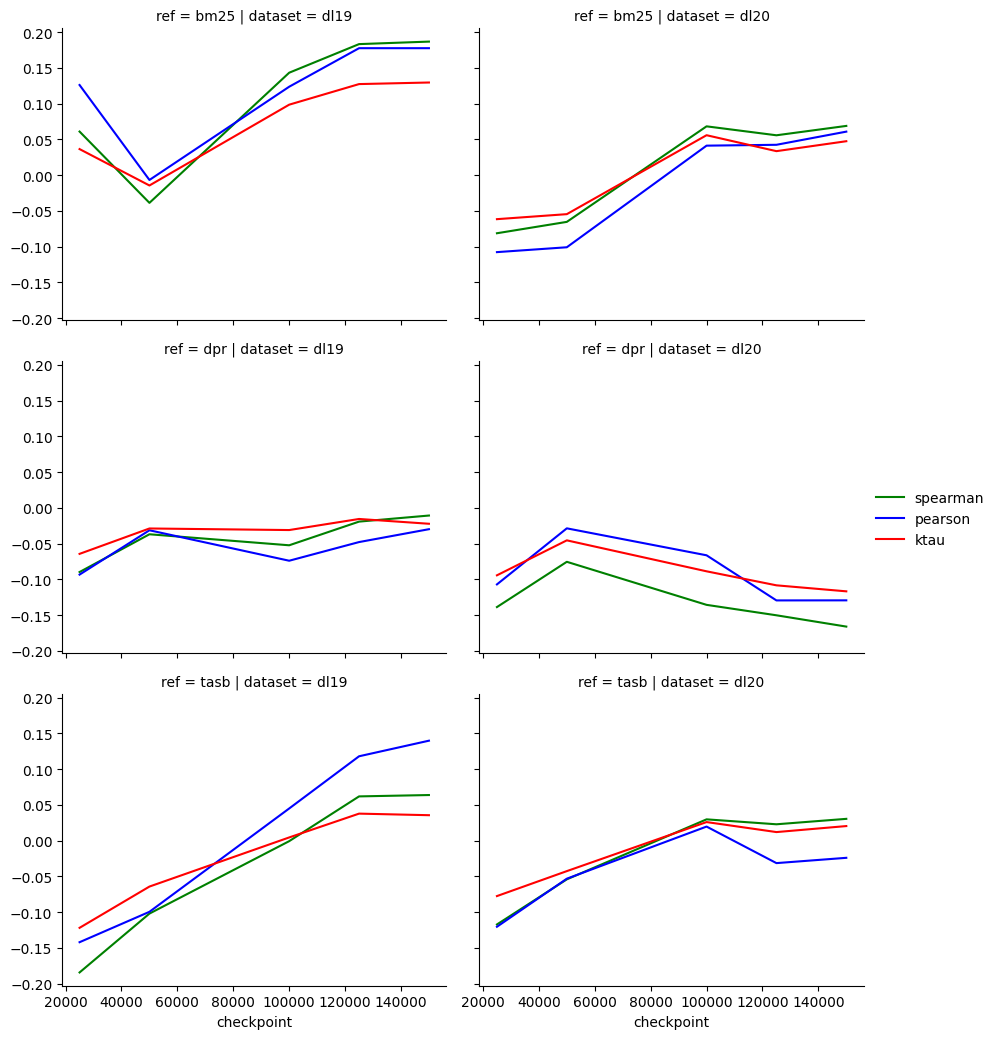

In [62]:
g = sns.FacetGrid(df, col="dataset", row="ref", height=3.5, aspect=1.3, sharey=True)
g.map(sns.lineplot, "checkpoint", "spearman", data=df, color="green", label="spearman")
g.map(sns.lineplot, "checkpoint", "pearson", data=df, color="blue", label="pearson")
g.map(sns.lineplot, "checkpoint", "ktau", data=df, color="red", label="ktau")
g.set_ylabels("")
g.add_legend()
g.savefig("figures/qpp_checkpoint.png")

In [70]:
sel={"MVRL (ND, LV)": 14, "MVRL-ND-TASB-Logvar-2GPU": 28, "MVRL-(ND, LV BZ-128)": 128, "MVRL-(ND, LV BZ-256)": 256, "MVRL-(ND, LV BZ-512)": 512}
bz_df = all_res_df[all_res_df.model.apply(lambda _: _ in sel)].copy()
bz_df["bz"] = bz_df.model.apply(lambda _: sel[_])
bz_df_ = []
for row in bz_df.to_dict("records"):
    for col in bz_df.columns:
        if col in {"model", "bz"}:
            continue
        bz_df_.append({
            "model": row["model"],
            "bz": row["bz"],
            "dataset": col.split("_")[0],
            "metric": "_".join(col.split("_")[1:]),
            "value": row[col]
        })
bz_df = pd.DataFrame(bz_df_)


/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


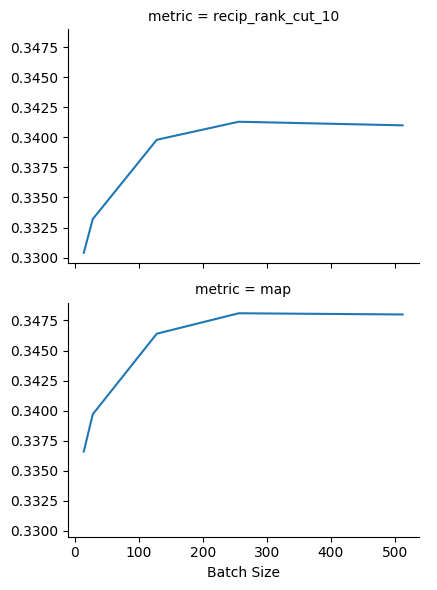

In [67]:
# plt.figure()
msm_bz_df = bz_df.query("dataset == 'dev'")
g = sns.FacetGrid(msm_bz_df, row="metric", aspect=1.5)
g.map(sns.lineplot, "bz", "value", data=bz_df)
g.set_ylabels("")
g.set_xlabels("Batch Size")
#plt.suptitle("MSMARCO Dev", y=0, x=0.57)
g.add_legend()
g.savefig("figures/msm_bz.png")
# sns.lineplot(x="bz", y="dev_map", data=bz_df)
# sns.lineplot(x="bz", y="dev_recip_rank_cut_10", data=bz_df)
# plt.show()

/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


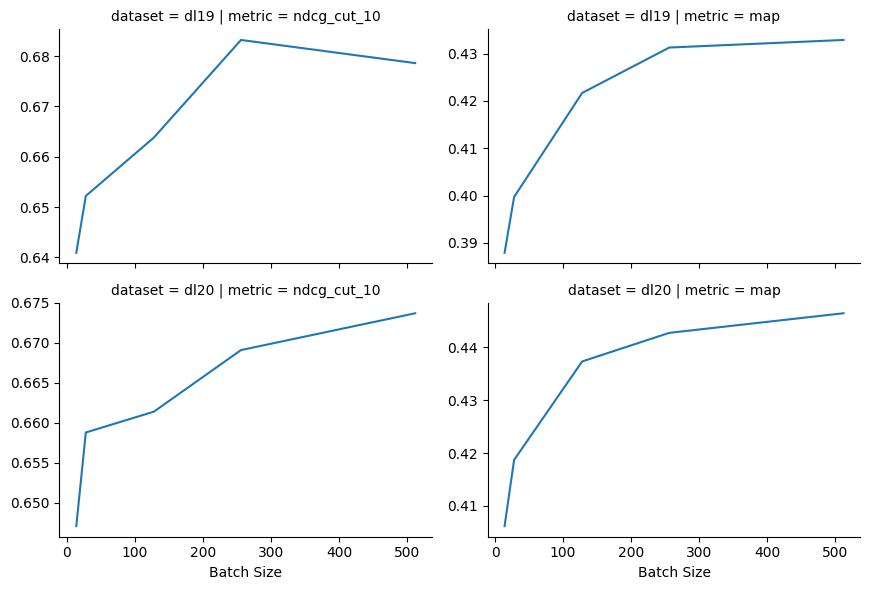

In [68]:
dl_bz_df = bz_df.query("dataset == 'dl19' or dataset == 'dl20'")
g = sns.FacetGrid(dl_bz_df, col="metric", row="dataset", aspect=1.5, sharey=False)
g.map(sns.lineplot, "bz", "value", data=dl_bz_df)
g.set_ylabels("")
g.set_xlabels("Batch Size")
#plt.suptitle("DL19/20", y=0, x=0.55)
g.savefig("figures/dl1920_bz.png")

/Users/sam/miniconda3/envs/multivariate_ir/lib/python3.8/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


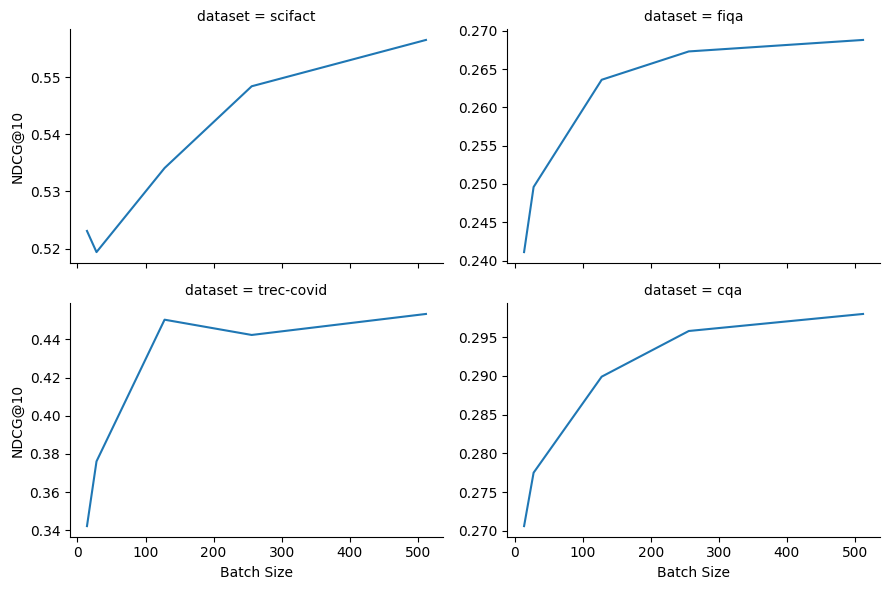

In [69]:
zs_bz_df = bz_df.query("dataset != 'dl19' and dataset != 'dl20' and dataset != 'dev'")
g = sns.FacetGrid(zs_bz_df, col="dataset", col_wrap=2, aspect=1.5, sharey=False)
g.map(sns.lineplot, "bz", "value", data=zs_bz_df)
g.set_ylabels("NDCG@10")
g.set_xlabels("Batch Size")
g.savefig("figures/zs_bz.png")

### Dataset statistics


In [5]:
import datasets
from transformers import AutoConfig, AutoTokenizer

In [36]:
def get_statistics(name, corpus, query, tokenizer_name="distilbert-base-uncased"):

    def count_tokens(dataset, field):
        counts = dataset.map(lambda _: {"n_toks": len(tokenizer(_[field])["input_ids"])})
        return np.sum(counts["n_toks"])
        
    
    if "beir" in corpus:
        corpus = datasets.load_dataset("Tevatron/beir-corpus", corpus.split(":")[-1], split="train")
        query = datasets.load_dataset("Tevatron/beir", query.split(":")[-1], split="test")
    else:
        corpus = datasets.load_dataset(corpus, split="train")
        try:
            query = datasets.load_dataset(query)
        except:
            _ = query.split("/")
            query = datasets.load_dataset("/".join(_[:2]), split=_[-1])
        
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    
    return {
        "name": name,
        "nQ": len(query),
        "nD": len(corpus),
        "nQToks": count_tokens(query, "query"),
        "nDToks": count_tokens(corpus, "text")
    }


DATASETS = {
    "MSMARCO": ("Tevatron/msmarco-passage-corpus", "Tevatron/msmarco-passage/dev"),
    "TREC-DL19": ("Tevatron/msmarco-passage-corpus", "Tevatron/msmarco-passage/dl19"),
    "TREC-DL20": ("Tevatron/msmarco-passage-corpus", "Tevatron/msmarco-passage/dl20"),
    "Scifact": ("Tevatron/scifact-corpus", "Tevatron/scifact/dev"),
}
CQA = ["cqadupstack-android", "cqadupstack-english", "cqadupstack-gaming", "cqadupstack-gis",
       "cqadupstack-wordpress", "cqadupstack-physics", "cqadupstack-programmers",
       "cqadupstack-stats", "cqadupstack-tex", "cqadupstack-unix",
       "cqadupstack-webmasters", "cqadupstack-wordpress", "cqadupstack-mathematica"]

for d in ["fiqa", "trec-covid"] + CQA:
    DATASETS[d] = (f"Tevatron/beir-corpus:{d}", f"Tevatron/beir:{d}")


d_stats = []

for d, (corpus, query) in DATASETS.items():
    d_stats.append(get_statistics(d, corpus, query))

d_stats = pd.DataFrame(d_stats)
row = d_stats[d_stats["name"].apply(lambda _: _.startswith("cqa"))].sum()
row = row.to_dict()
row["name"] = "cqadupstack"
d_stats = pd.concat([d_stats[d_stats["name"].apply(lambda _: not _.startswith("cqa"))], pd.DataFrame([row])])

Reusing dataset msmarco-passage-corpus (/Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage-corpus/default/0.0.1/3d8add51914a7d2b589d09e37f4cd9646ebe4a3bad6d59b4e3702cfcc9941f23)
Reusing dataset msmarco-passage (/Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage/default/0.0.1/300947ae554083632b487251f17ce2100425fd1135048532fb20afa1d66e9e62)
Loading cached processed dataset at /Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage/default/0.0.1/300947ae554083632b487251f17ce2100425fd1135048532fb20afa1d66e9e62/cache-42e7728fe43ace96.arrow
Loading cached processed dataset at /Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage-corpus/default/0.0.1/3d8add51914a7d2b589d09e37f4cd9646ebe4a3bad6d59b4e3702cfcc9941f23/cache-9e328a5f004a0087.arrow
Reusing dataset msmarco-passage-corpus (/Users/sam/.cache/huggingface/datasets/Tevatron___msmarco-passage-corpus/default/0.0.1/3d8add51914a7d2b589d09e37f4cd9646ebe4a3bad6d59b4e3702cfcc9941f23)
Reusing 

In [39]:
d_stats["avgQLen"] = d_stats["nQToks"] / d_stats["nQ"]
d_stats["avgDLen"] = d_stats["nDToks"] / d_stats["nD"]
d_stats

,name,nQ,nD,nQToks,nDToks,avgQLen,avgDLen
0,MSMARCO,6980,8841823,62958,680584022,9.019771,76.973269
1,TREC-DL19,43,8841823,388,680584022,9.023256,76.973269
2,TREC-DL20,54,8841823,498,680584022,9.222222,76.973269
3,Scifact,300,5183,6853,1636015,22.843333,315.650203
4,fiqa,648,57638,10103,10208682,15.591049,177.117214
5,trec-covid,50,171332,902,38511584,18.040000,224.777531
0,cqadupstack,13145,457199,178157,113720074,13.553214,248.732114
